In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Define the CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride = 1, padding = 1)

        """self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Global average pooling (GAP) to reduce the output to size [batch_size, out_channels, 1, 1]
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Final convolution layer to map to the number of output classes
        self.conv_out = nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1)"""

    def forward(self, x):
        x = F.relu(self.conv1(x))
        for i in range(8):
            x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        return x

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Hyperparameters
# batch_size = 64
# learning_rate = 0.001
# num_epochs = 5

# # Data loading
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize the network and optimizer
# model = SimpleCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for data, targets in train_loader:
#         data, targets = data.to(device), targets.to(device)
        
#         # Forward pass
#         outputs = model(data)
#         loss = criterion(outputs, targets)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
    
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# # Test the model
# model.eval()
# correct = 0
# total = 0

# with torch.no_grad():
#     for data, targets in test_loader:
#         data, targets = data.to(device), targets.to(device)
#         outputs = model(data)
#         _, predicted = torch.max(outputs, 1)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

# print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')


d:\Users\draar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'D:\Users\draar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


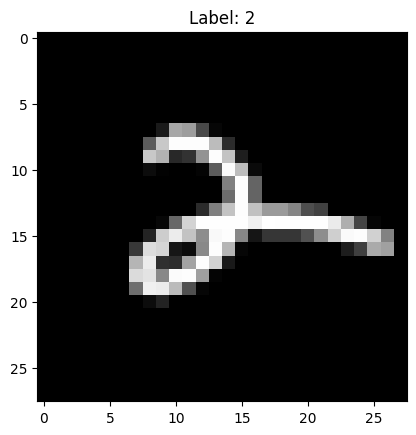

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize for MNIST
])

# Load the MNIST dataset (just for testing, download=True)
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load a single image using DataLoader
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)

# Get one batch (one image and its label)
image, label = next(iter(data_loader))

# Remove batch dimension for visualization (1, 28, 28 -> 28, 28)
image2 = image.squeeze()

# Plot the image using matplotlib
plt.imshow(image2, cmap='gray')
plt.title(f"Label: {label.item()}")
plt.show()

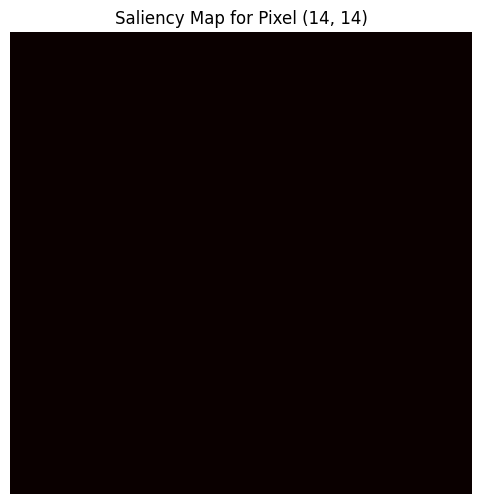

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=60000, shuffle=False)
images, _ = next(iter(train_loader))


def preprocess_image(img_path):
    img = Image.open(img_path).convert('L')
    preprocess = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

def generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel):
    img_tensor.requires_grad_()  # Enable gradients for input
    output = model(img_tensor)   # Forward pass through CNN layers
    
    # Select the target pixel from the feature map (height, width) coordinates
    h, w = target_layer_pixel
    target_feature = output[0, :, h, w]  # Select the specific pixel at (h, w)
    
    # Sum the feature map pixel values to treat it as a scalar target for gradients
    scalar_target = target_feature.sum()
    model.zero_grad()
    
    # Backpropagate the gradient from this pixel
    scalar_target.backward()
    
    # Get the gradient of the input image
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)  # Max across color channels
    saliency = saliency.squeeze().cpu().numpy()  # Convert to numpy
    
    return saliency

# Plot and visualize the saliency map
def visualize_saliency_map_for_pixel(img_path, target_layer_pixel=(0, 0)):
    model = SimpleCNN()  # Ensure your SimpleCNN model is defined
    model.eval()  # Set model to evaluation mode
    
    img_tensor = img_path #changed to just inputing the actual image
    saliency = generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title(f'Saliency Map for Pixel {target_layer_pixel}')
    plt.show()

visualize_saliency_map_for_pixel(image, (15, 15))
